threshold [0.41360804]
threshold [0.34941427]
threshold [0.49868738]
threshold [0.39397304]
threshold [0.40197408]
threshold [0.49367149]
threshold [0.4127741]
threshold [0.37092112]
threshold [0.48659986]
threshold [0.41684061]
threshold [0.38414639]
threshold [0.28442779]
threshold [0.20356829]
threshold [0.48389833]
threshold [0.07327201]
threshold [0.25419963]
threshold [0.31752869]
threshold [0.39631212]
threshold [0.43813303]
threshold [0.35140655]
threshold [0.41626407]


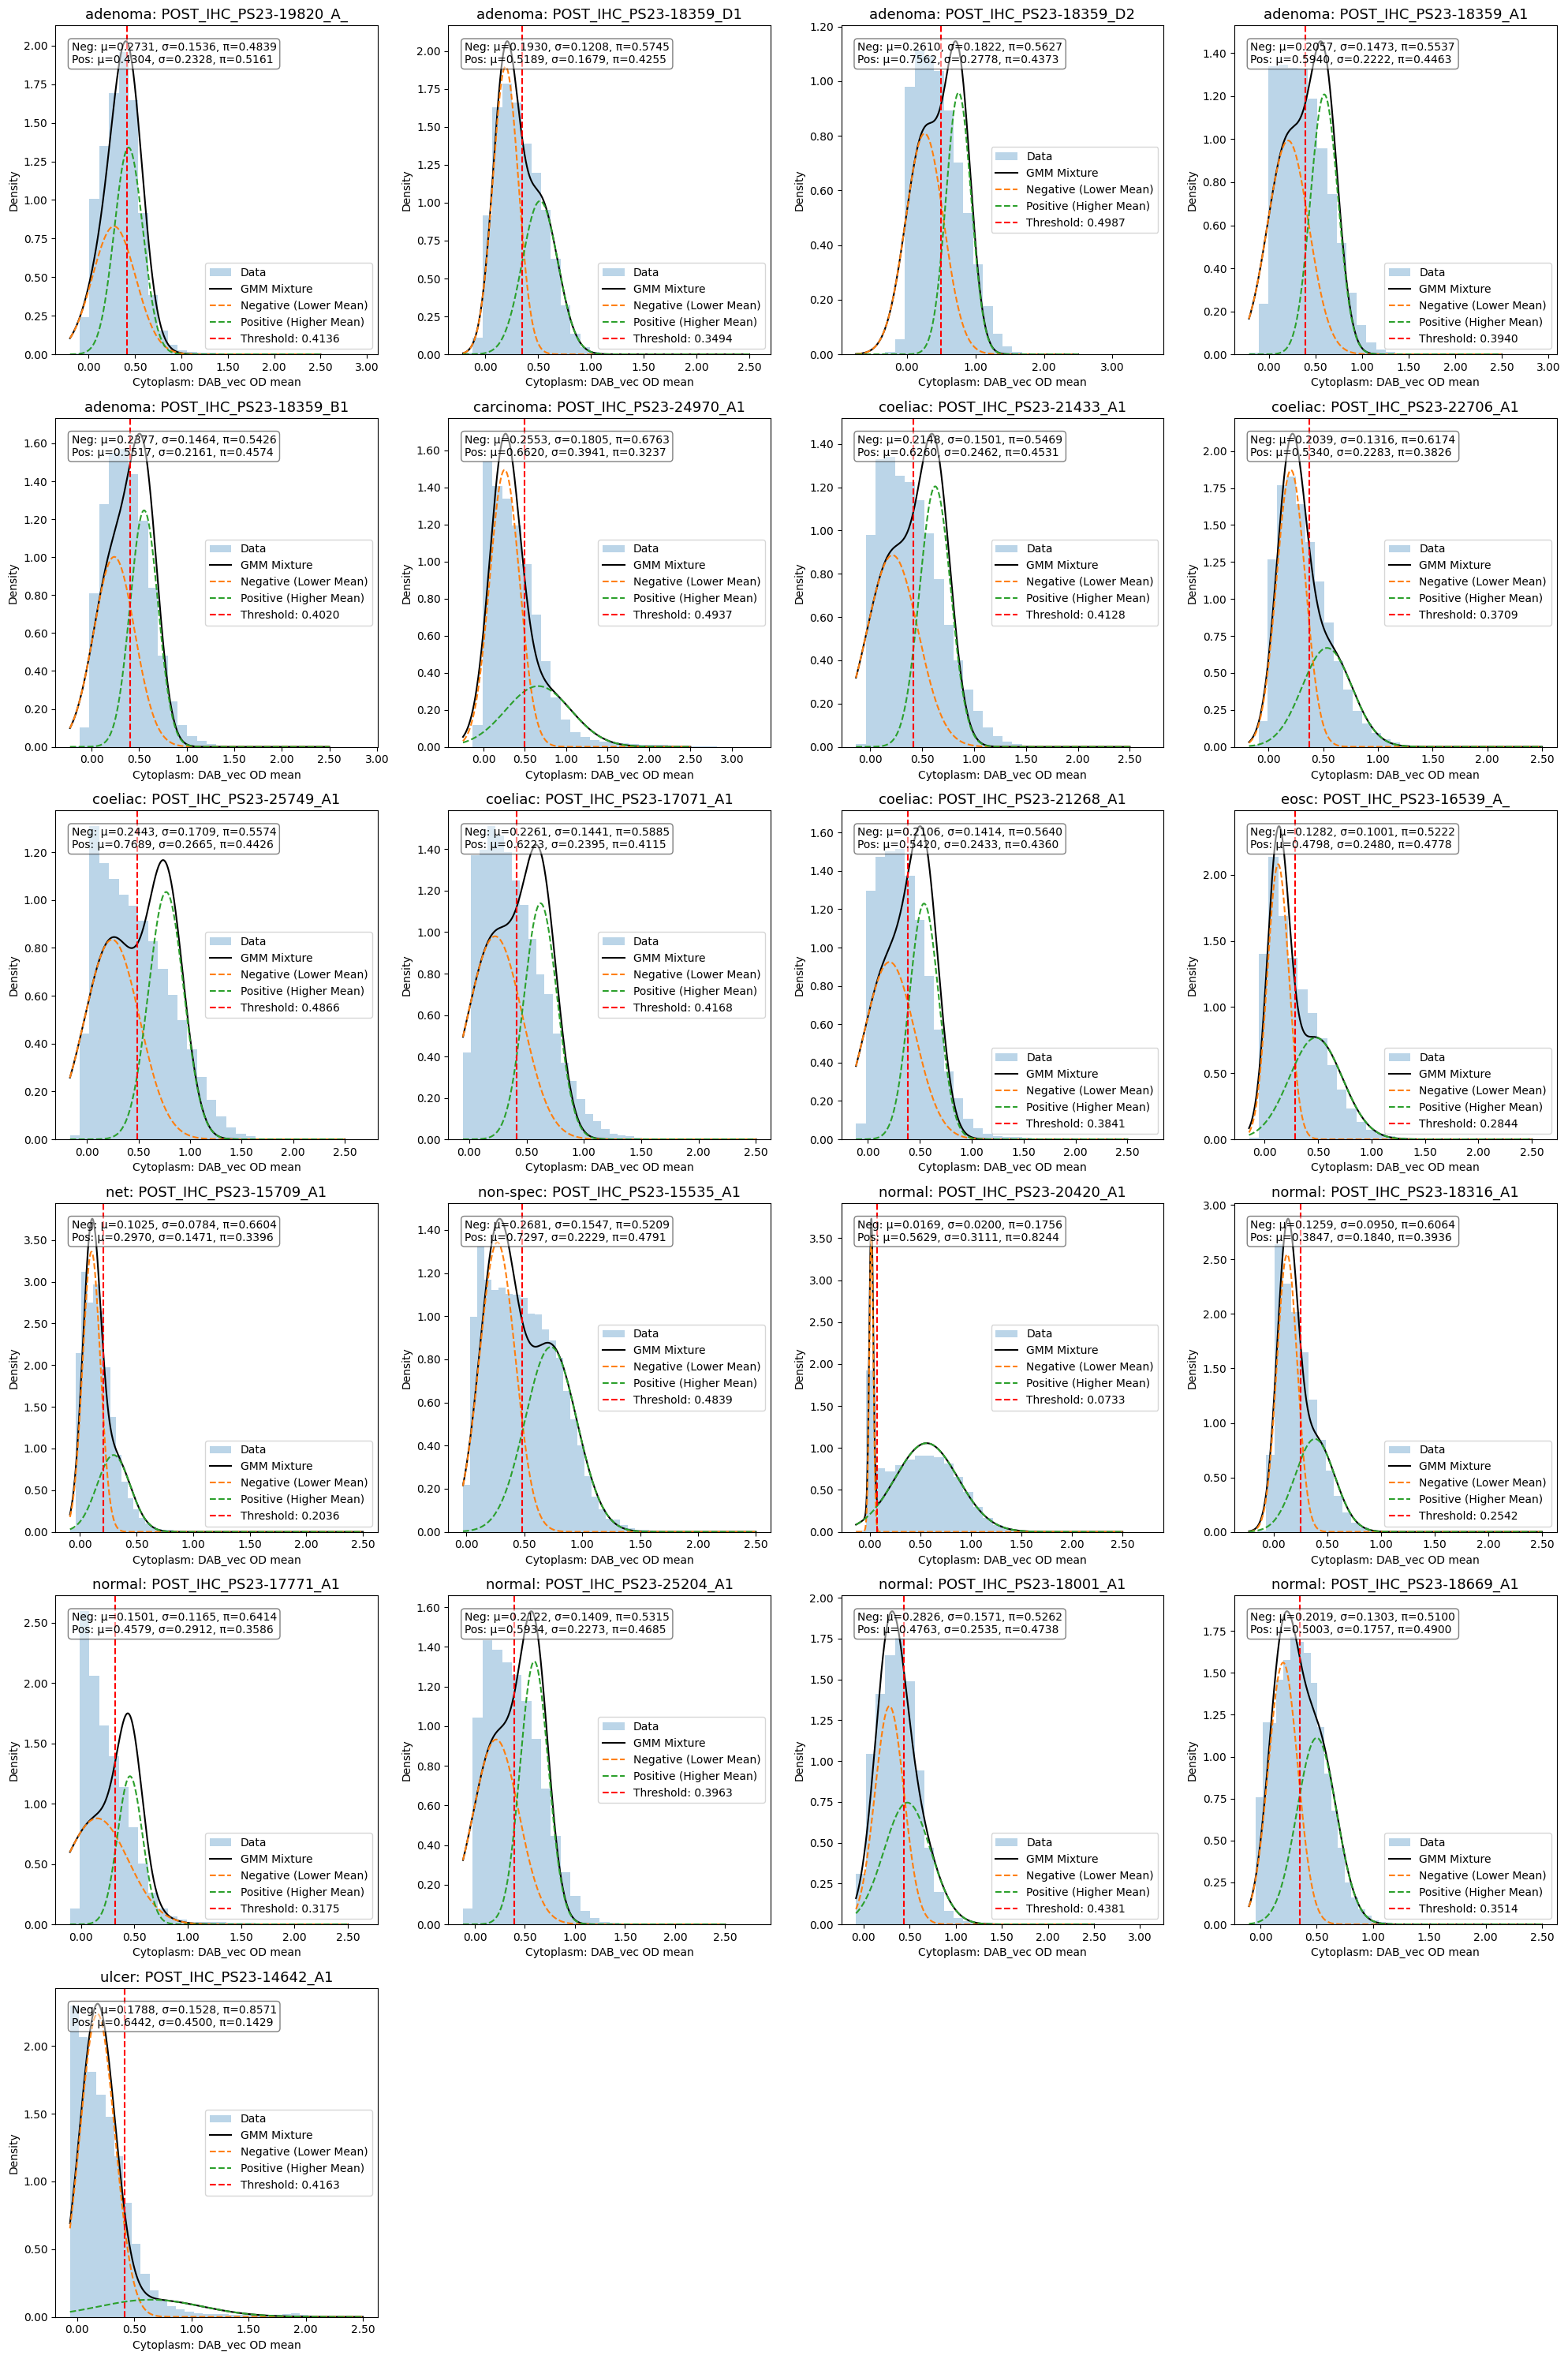

In [2]:
import pandas as pd
import numpy as np
import glob
import os
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from scipy.stats import norm

file_names = {
    "POST_IHC_PS23-14642_A1_ulcer_HE-CK_aligned.ome.csv": "ulcer",
    "POST_IHC_PS23-15535_A1_non-spec_HE-CK.svs_aligned.ome.csv": "non-spec",
    "POST_IHC_PS23-15709_A1_PS23-20460_net_HE-CK.svs_aligned.ome.csv": "net",
    "POST_IHC_PS23-16539_A_PS23-16539_B1_PS23-10072_A1_eosc_HE-CK.svs_aligned.ome.csv": "eosc",
    "POST_IHC_PS23-17071_A1_cd_HE-CK.svs_aligned.ome.csv" : "coeliac",
    "POST_IHC_PS23-17771_A1_PS23-17948_normal_HE-CK.svs_aligned.ome.csv": "normal",
    "POST_IHC_PS23-18001_A1_normal_HE-CK.svs_aligned.ome.csv": "normal",
    "POST_IHC_PS23-18316_A1_PS23-18379_A1_PS23-18656_A1_normal_HE-CK.svs_aligned.ome.csv": "normal",
    "POST_IHC_PS23-18359_A1_adenoma_HE-CK.svs_aligned.ome.csv": "adenoma",
    "POST_IHC_PS23-18359_B1_adenoma_HE-CK.svs_aligned.ome.csv": "adenoma",
    "POST_IHC_PS23-18359_D1_adenoma_HE-CK.svs_aligned.ome.csv": "adenoma",
    "POST_IHC_PS23-18359_D2_adenoma_HE-CK.svs_aligned.ome.csv": "adenoma",
    "POST_IHC_PS23-18669_A1_normal_HE-CK.svs_aligned.ome.csv": "normal",
    "POST_IHC_PS23-19820_A_PS23-20019_A1_PS23-20493_A1_adenoma_HE-CK.svs_aligned.ome.csv": "adenoma",
    "POST_IHC_PS23-20420_A1_PS23-20442_A1_normal_HE-CK.svs_aligned.ome.csv": "normal",
    "POST_IHC_PS23-21268_A1_PS23-21268_B1_cd_HE-CK.svs_aligned.ome.csv": "coeliac",
    "POST_IHC_PS23-21433_A1_PS23-21433_B1_PS23-22604_A1_cd_HE-CK.svs_aligned.ome.csv": "coeliac",
    "POST_IHC_PS23-22706_A1_PS23-22706_B1_PS23-24449_A1_cd_HE-CK.svs_aligned.ome.csv": "coeliac",
    "POST_IHC_PS23-24970_A1_PS23-09489_A1_carcinoma_HE-CK.svs_aligned.ome.csv": "carcinoma",
    "POST_IHC_PS23-25204_A1_PS23-17242_A1_normal_HE-CK.svs_aligned.ome.csv": "normal",
    "POST_IHC_PS23-25749_A1_PS23-28165_A1_cd_HE-CK.svs_aligned.ome.csv": "coeliac"
}
# Load all CSV files from a directory
def load_data_from_directory(directory):
    file_paths = glob.glob(os.path.join(directory, "*.csv"))
    dataframes = [pd.read_csv(file) for file in file_paths]
    return dataframes, file_paths

def find_threshold(mean1, std1, mean2, std2, weight1, weight2):
    """Find the optimal DAB threshold where the two Gaussians have equal probability."""
    a = 1/(2*std1**2) - 1/(2*std2**2)
    b = mean2/(std2**2) - mean1/(std1**2)
    c = mean1**2 /(2*std1**2) - mean2**2 / (2*std2**2) - np.log(std2/std1)
    roots = np.roots([a,b,c])
    return roots[np.logical_and(roots > mean1, roots < mean2)]  # Choose the root within the means

# Fit a Gaussian Mixture Model (GMM)
def fit_gmm(data, column, n_components=2):
    values = data[column].dropna().values.reshape(-1, 1)
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(values)
    
    # Sort components by mean
    sorted_indices = np.argsort(gmm.means_.flatten())
    gmm.means_ = gmm.means_[sorted_indices]
    gmm.covariances_ = gmm.covariances_[sorted_indices]
    gmm.weights_ = gmm.weights_[sorted_indices]
    # print(gmm.weights_)
    # print(gmm.aic)
    
    return gmm, values


def format_axis(ax):
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.2f}"))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.2f}"))


def plot_all_gmms(gmms, values_list, file_names_list, column_name):
    num_files = len(file_names_list)
    num_rows = int(np.ceil(num_files / 4))  # Adjust to fit 4 columns per row
    fig, axes = plt.subplots(num_rows, 4, figsize=(20, num_rows * 5))
    axes = axes.flatten()
    
    for i, (gmm, values, file_name) in enumerate(zip(gmms, values_list, file_names_list)):
        ax = axes[i]
        x = np.linspace(min(values), 2.50, 10000).reshape(-1, 1)
        logprob = gmm.score_samples(x)
        responsibilities = gmm.predict_proba(x)
        pdf = np.exp(logprob)
        pdf_individual = responsibilities * pdf[:, np.newaxis]
        
        ax.hist(values, bins=30, density=True, alpha=0.3, label='Data')
        ax.plot(x, pdf, label='GMM Mixture', color='black')
        ax.plot(x, pdf_individual[:, 0], linestyle='dashed', label='Negative (Lower Mean)')
        ax.plot(x, pdf_individual[:, 1], linestyle='dashed', label='Positive (Higher Mean)')
        
        means = gmm.means_.flatten()
        std_devs = np.sqrt(gmm.covariances_.flatten())
        weights = gmm.weights_

        # Compute the threshold where the two Gaussian distributions intersect
        threshold = find_threshold(means[0], std_devs[0], means[1], std_devs[1], weights[0], weights[1])
        print("threshold", threshold)
        
        try:
            ax.axvline(threshold[0], color='red', linestyle='--', label=f'Threshold: {threshold[0]:.4f}')
        except:
            print("error occurred")

        ax.text(0.05, 0.95, f"Neg: μ={means[0]:.4f}, σ={std_devs[0]:.4f}, π={gmm.weights_[0]:.4f}\nPos: μ={means[1]:.4f}, σ={std_devs[1]:.4f}, π={gmm.weights_[1]:.4f}",
                transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
        
        short_name = os.path.basename(file_name)[:22]
        category = file_names[os.path.basename(file_name)]
        ax.set_title(f"{category}: {short_name}", fontsize=13)
        ax.set_xlabel(column_name)
        ax.set_ylabel('Density')
        ax.legend()
        format_axis(ax)
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.savefig("gaussian_mixtures.png")
    plt.show()


# Main execution
def main():
    directory = "CK_distributions"  # Change to the actual directory path
    column_name = "Cytoplasm: DAB_vec OD mean"
    dataframes, file_paths = load_data_from_directory(directory)

    labeled_files = [(file, file_names[os.path.basename(file)]) for file in file_paths if os.path.basename(file) in file_names]
    labeled_files.sort(key=lambda x: x[1])  # Sort by diagnosis label
    
    sorted_file_paths = [file for file, label in labeled_files]
    sorted_labels = [label for file, label in labeled_files]
    
    gmms = []
    values_list = []
    disease_stats = {"ulcer": [],
                     "normal": [],
                     "coeliac": [],
                     "eosc": [],
                     "adenoma": [],
                     "carcinoma": [],
                     "net": [],
                     "non-spec": []

    } 
    
    # Process in sorted order
    for file in sorted_file_paths:
        df = pd.read_csv(file)
        gmm, values = fit_gmm(df, column_name)
        gmms.append(gmm)
        values_list.append(values)
        category = file_names[os.path.basename(file)]
        means = gmm.means_.flatten()
        std_devs = np.sqrt(gmm.covariances_.flatten())
        disease_stats[category].append((means, std_devs))
    
    plot_all_gmms(gmms, values_list, sorted_file_paths, column_name)
    
    table_data = []

    for category, stats in disease_stats.items():
        neg_means, pos_means, neg_stds, pos_stds = zip(*[(m[0], m[1], s[0], s[1]) for m, s in stats])
        
        row = {
            "Disease": category,
            "Neg Mean": np.mean(neg_means),
            "Neg Std Dev": np.mean(neg_stds),
            "Pos Mean": np.mean(pos_means),
            "Pos Std Dev": np.mean(pos_stds)
        }
        table_data.append(row)

    df = pd.DataFrame(table_data)

    # Print the table in a readable format
    # print(df.to_string(index=False))
    df.to_csv("summary_gaussian_stats.csv")

    """
    print(disease_stats)
    gaussian_stats = pd.DataFrame(disease_stats)
    gaussian_stats.to_csv("guassian_stats.csv")"
    """

if __name__ == "__main__":
    main()

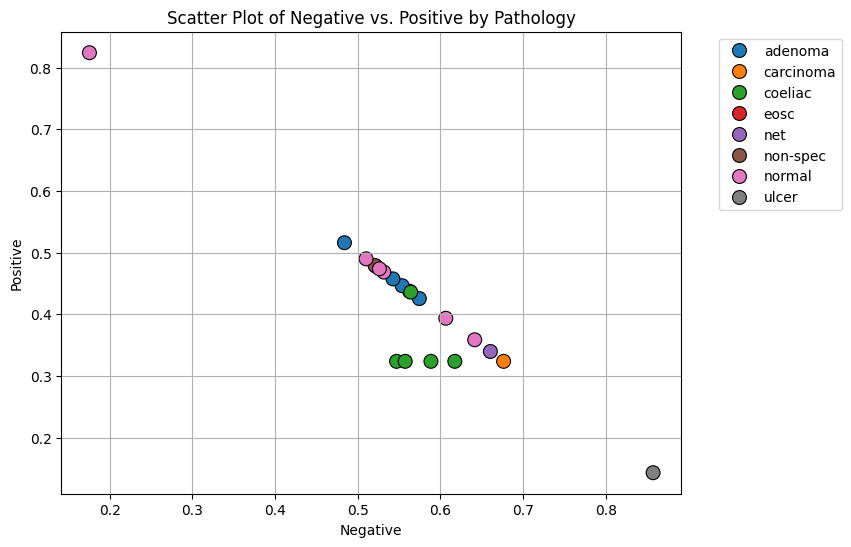

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data
data = {
    "Pathology": ["adenoma", "adenoma", "adenoma", "adenoma", "adenoma", 
                  "carcinoma", "coeliac", "coeliac", "coeliac", "coeliac", 
                  "coeliac", "eosc", "net", "non-spec", "normal", "normal", 
                  "normal", "normal", "normal", "normal", "ulcer"],
    "Negative": [0.483908, 0.574464, 0.562694, 0.553677, 0.542582, 
                 0.67635, 0.546929, 0.617355, 0.557369, 0.58847, 
                 0.564024, 0.522198, 0.66036, 0.520947, 0.175628, 0.606444, 
                 0.641396, 0.531525, 0.526213, 0.510043, 0.857087],
    "Positive": [0.516092, 0.425536, 0.437306, 0.446323, 0.457418, 
                 0.32365, 0.32365, 0.32365, 0.32365, 0.32365, 
                 0.435976, 0.477802, 0.33964, 0.479053, 0.824372, 0.393556, 
                 0.358604, 0.468475, 0.473787, 0.489957, 0.142913]
}

# Create DataFrame
df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="Negative", y="Positive", hue="Pathology", palette="tab10", s=100, edgecolor="black")

# Labels and Title
plt.xlabel("Negative")
plt.ylabel("Positive")
plt.title("Scatter Plot of Negative vs. Positive by Pathology")

# Show plot
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")  # Move legend outside
plt.grid(True)
plt.show()

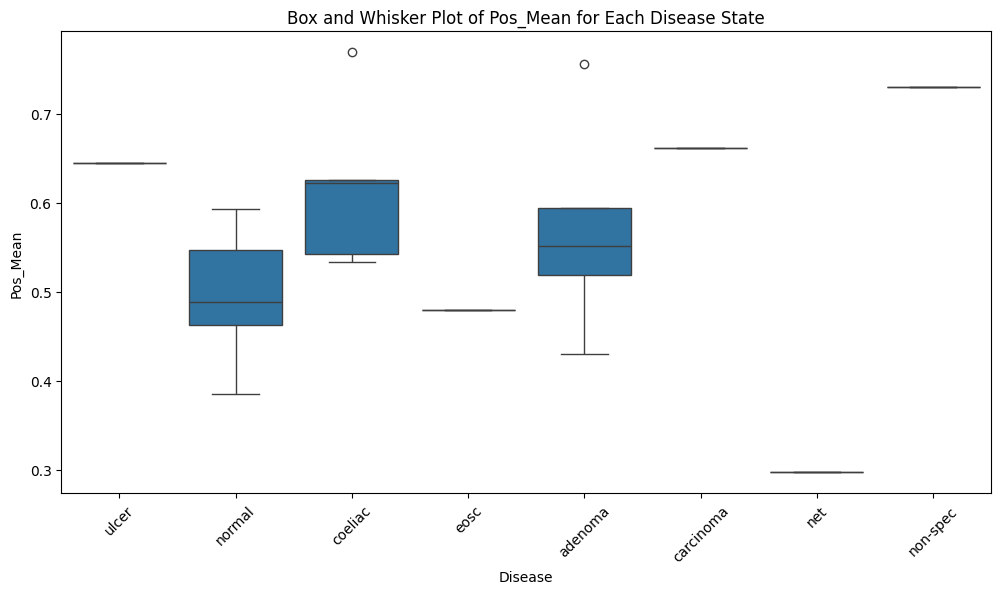

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Data dictionary
disease_data = {
    'ulcer': [(np.array([0.17875974, 0.64424618]), np.array([0.15275881, 0.44995595]))],
    'normal': [(np.array([0.01686849, 0.562898]), np.array([0.01998266, 0.31113332])),
               (np.array([0.12586889, 0.38465377]), np.array([0.09500688, 0.18397992])),
               (np.array([0.15011736, 0.45785936]), np.array([0.11652641, 0.29120694])),
               (np.array([0.21218583, 0.59337715]), np.array([0.14085418, 0.22732485])),
               (np.array([0.28261328, 0.47629009]), np.array([0.15712418, 0.25354806])),
               (np.array([0.20192489, 0.50030809]), np.array([0.1303062, 0.17569115]))],
    'coeliac': [(np.array([0.21481894, 0.62598024]), np.array([0.15007279, 0.24617041])),
                (np.array([0.20386315, 0.53395852]), np.array([0.13158113, 0.2282694])),
                (np.array([0.2442972, 0.76890234]), np.array([0.1708539, 0.26648608])),
                (np.array([0.22612067, 0.62225904]), np.array([0.14409374, 0.23952159])),
                (np.array([0.2105678, 0.54202238]), np.array([0.14144945, 0.2433228]))],
    'eosc': [(np.array([0.12819001, 0.47980975]), np.array([0.10013702, 0.24796507]))],
    'adenoma': [(np.array([0.27313442, 0.43035137]), np.array([0.15363196, 0.23275628])),
                (np.array([0.19300739, 0.51885914]), np.array([0.1207508, 0.16789583])),
                (np.array([0.26095616, 0.75617378]), np.array([0.18217046, 0.27778947])),
                (np.array([0.20573379, 0.5940208]), np.array([0.14733606, 0.22222115])),
                (np.array([0.23771506, 0.55173301]), np.array([0.14635772, 0.21608955]))],
    'carcinoma': [(np.array([0.25530301, 0.66201109]), np.array([0.18049504, 0.39405742]))],
    'net': [(np.array([0.10249768, 0.29697556]), np.array([0.07840486, 0.14710928]))],
    'non-spec': [(np.array([0.26805755, 0.72965793]), np.array([0.15474244, 0.22288714]))]
}

# Extract data for plotting
disease_states = []
pos_means = []

for disease, values in data.items():
    for neg_pos_means, _ in values:
        pos_means.append(neg_pos_means[1])  # Second element of array is pos_mean
        disease_states.append(disease)

# Create a DataFrame
import pandas as pd
df = pd.DataFrame({'Disease': disease_states, 'Pos_Mean': pos_means})

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(x='Disease', y='Pos_Mean', data=df)
plt.xticks(rotation=45)
plt.title('Box and Whisker Plot of Pos_Mean for Each Disease State')
plt.show()

In [24]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA

# Sample data (replace this with your actual data)
data = {
    "Disease": ["ulcer", "normal", "normal", "normal", "normal", "normal", "normal", "coeliac", "coeliac", "coeliac", 
                "coeliac", "coeliac", "eosc", "adenoma", "adenoma", "adenoma", "adenoma", "adenoma", "carcinoma", 
                "net", "non-spec"],
    "Pos_Mean": [0.152759, 0.019983, 0.095007, 0.116526, 0.140854, 0.157124, 0.130306, 0.150073, 0.131581, 0.170854, 
                 0.144094, 0.141449, 0.100137, 0.153632, 0.120751, 0.182170, 0.147336, 0.146358, 0.180495, 0.078405, 
                 0.154742],
    "Neg_Mean": [0.178760, 0.016868, 0.125869, 0.150117, 0.212186, 0.282613, 0.201925, 0.214819, 0.203863, 0.244297, 
                 0.226121, 0.210568, 0.128190, 0.273134, 0.193007, 0.260956, 0.205734, 0.237715, 0.255303, 0.102498, 
                 0.268058],
    "Pos_Std_Dev": [0.449956, 0.311133, 0.183980, 0.291207, 0.227325, 0.253548, 0.175691, 0.246170, 0.228269, 0.266486, 
                    0.239522, 0.243323, 0.247965, 0.232756, 0.167896, 0.277789, 0.222221, 0.216090, 0.394057, 0.147109, 
                    0.222887],
    "Neg_Std_Dev": [0.644246, 0.562898, 0.384654, 0.457859, 0.593377, 0.476290, 0.500308, 0.625980, 0.533959, 0.768902, 
                    0.622259, 0.542022, 0.479810, 0.430351, 0.518859, 0.756174, 0.594021, 0.551733, 0.662011, 0.296976, 
                    0.729658]
}

df = pd.DataFrame(data)

# Fit the MANOVA model
manova = MANOVA.from_formula('Pos_Mean + Neg_Mean + Pos_Std_Dev + Neg_Std_Dev ~ Disease', data=df)

# Perform the MANOVA test and print the results
print(manova.mv_test())


                  Multivariate linear model
                                                             
-------------------------------------------------------------
       Intercept         Value  Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda  0.0395 4.0000 10.0000 60.7797 0.0000
         Pillai's trace  0.9605 4.0000 10.0000 60.7797 0.0000
 Hotelling-Lawley trace 24.3119 4.0000 10.0000 60.7797 0.0000
    Roy's greatest root 24.3119 4.0000 10.0000 60.7797 0.0000
-------------------------------------------------------------
                                                             
-------------------------------------------------------------
        Disease         Value   Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.0385 28.0000 37.4777  1.9646 0.0270
         Pillai's trace 1.7960 28.0000 52.0000  1.5133 0.0973
 Hotelling-Lawley trace 7.